In [5]:
import sys
sys.path.append("Desktop/diabetes_predictor-master")
import numpy as np
import pandas as pd
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

df = pd.read_csv("~/Desktop/diabetes_predictor-master/dataset_diabetes/diabetes_data_preprocessed_improved.csv")

df.shape
df.info()

df['readmitted'] = df['readmitted'].replace('>30', 2)
df['readmitted'] = df['readmitted'].replace('<30', 1)
df['readmitted'] = df['readmitted'].replace('NO', 0)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61675 entries, 0 to 61674
Data columns (total 20 columns):
Unnamed: 0                  61675 non-null int64
age                         61675 non-null float64
time_in_hospital            61675 non-null float64
num_lab_procedures          61675 non-null float64
num_procedures              61675 non-null float64
number_diagnoses            61675 non-null float64
nummed                      61675 non-null float64
numchange                   61675 non-null float64
readmitted                  61675 non-null int64
add_feature_1               61675 non-null float64
add_feature_2               61675 non-null float64
add_feature_3               61675 non-null float64
number_outpatient           61675 non-null float64
number_emergency            61675 non-null float64
number_inpatient            61675 non-null float64
race                        61675 non-null float64
admission_type_id           61675 non-null int64
discharge_disposition_id    61

In [6]:
feature_set_2_no_int = [
'age',                        
'time_in_hospital',           
'num_lab_procedures',         
'num_procedures',             
'number_diagnoses',           
'nummed',                       
'numchange',                  
'add_feature_1',               
'add_feature_2',               
'add_feature_3',
'number_outpatient',
'number_inpatient',
'number_emergency',
'race',
'admission_type_id',
'discharge_disposition_id',
'admission_source_id',
'diag_1'
]

the_input = df[feature_set_2_no_int]
the_output = df['readmitted']

from imblearn.over_sampling import SMOTE
from collections import Counter

smt = SMOTE(random_state=20)
train_input_new, train_output_new = smt.fit_sample(the_input, the_output)
train_input_new = pd.DataFrame(train_input_new, columns = list(the_input.columns))

X_train, X_test, Y_train, Y_test = train_test_split(train_input_new, train_output_new, test_size=0.20, random_state=0)

In [7]:
print(len(X_train), len(X_test), len(Y_train), len(Y_test))
print(X_test)
print(X_train)
print(Y_test)
print(Y_train)

90369 22593 90369 22593
             age  time_in_hospital  num_lab_procedures  num_procedures  \
85760   0.366293          1.821232            0.533766        2.608514   
39953  -0.032458         -0.776736           -0.247129       -0.810421   
21679  -0.658350         -0.096381           -0.297379        2.608514   
108751  0.066180          1.658118           -0.252599       -0.330400   
52837   0.593435         -0.776736           -0.146630        2.608514   
8391   -1.284243          2.965218            2.215094        1.468869   
67871  -0.869924          1.237981            0.488918       -0.810421   
91431  -0.990561         -0.797677            0.222508       -0.275675   
19600   0.593435         -0.096381           -0.247129       -0.240598   
34613   1.219327          0.243797            0.004118        0.329224   
110292 -0.658350         -1.021165           -0.267598       -0.240598   
36867  -0.658350         -0.436559            1.009107        0.329224   
13856   0.5934

In [8]:
# XGBOOST

# xg_reg = xgb.XGBClassifier(colsample_bytree=1, learning_rate=0.1, max_depth=5, n_estimators=250,
#                           objective='multi:softprob', subsample=1)
xg_reg = xgb.XGBClassifier()

print("Cross Validation score: ", np.mean(cross_val_score(xg_reg, X_train, Y_train, cv=10)))
xg_reg.fit(X_train,Y_train)

Y_test_predict = xg_reg.predict(X_test)
print("Accuracy: ",accuracy_score(Y_test, Y_test_predict))

Cross Validation score:  0.61666076846439


Accuracy:  0.6101889965918648


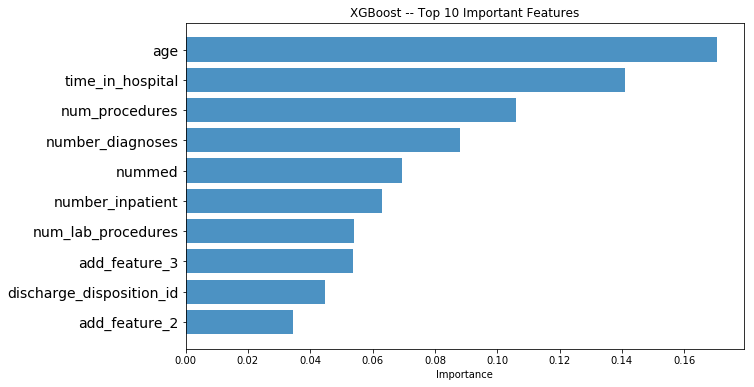

In [33]:
# XGBOOST TOP FEATURES DIAGRAM

feature_names = X_train.columns
feature_imports = xg_reg.feature_importances_
most_imp_features = pd.DataFrame([f for f in zip(feature_names,feature_imports)], columns=["Feature", "Importance"]).nlargest(10, "Importance")
most_imp_features.sort_values(by="Importance", inplace=True)
plt.figure(figsize=(10,6))
plt.barh(range(len(most_imp_features)), most_imp_features.Importance, align='center', alpha=0.8)
plt.yticks(range(len(most_imp_features)), most_imp_features.Feature, fontsize=14)
plt.xlabel('Importance')
plt.title('XGBoost -- Top 10 Important Features')
plt.show()

In [15]:
# RANDOM FOREST

forest = RandomForestClassifier(n_estimators = 100, max_depth=25, criterion = "entropy", min_samples_split=10)

#print("Cross Validation Score: ", np.mean(cross_val_score(forest, X_train, Y_train, cv=10)))
forest.fit(X_train, Y_train)

Y_test_predict = forest.predict(X_test)
print("Accuracy: ", accuracy_score(Y_test, Y_test_predict))

Accuracy:  0.6914973664409331


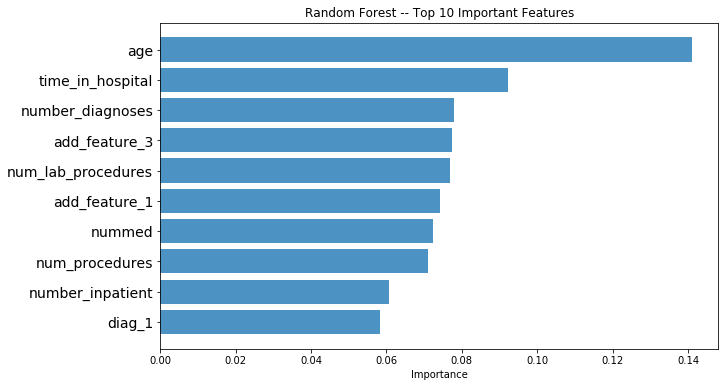

In [32]:
# RANDOM FOREST TOP FEATURES DIAGRAM

feature_names = X_train.columns
feature_imports = forest.feature_importances_
most_imp_features = pd.DataFrame([f for f in zip(feature_names,feature_imports)], columns=["Feature", "Importance"]).nlargest(10, "Importance")
most_imp_features.sort_values(by="Importance", inplace=True)
plt.figure(figsize=(10,6))
plt.barh(range(len(most_imp_features)), most_imp_features.Importance, align='center', alpha=0.8)
plt.yticks(range(len(most_imp_features)), most_imp_features.Feature, fontsize=14)
plt.xlabel('Importance')
plt.title('Random Forest -- Top 10 Important Features')
plt.show()

In [17]:
K = [30,40,50,60,70,80,90,100] # Or something else# #
A = [20,25,30,35,40,50,60,70,80] # Or something else 
tr_auc = np.zeros((len(K),len(A)))
for i,k in enumerate(K):
    for j,a in enumerate(A):
        forest = RandomForestClassifier(n_estimators = k, max_depth=a, criterion = "entropy", 
                                        min_samples_split=10)
        forest.fit(X_train, Y_train)
        Y_test_predict = forest.predict(X_test)
        tr_auc[i][j]=accuracy_score(Y_test, Y_test_predict)
        print(tr_auc[i][j])
        

0.667330589120524


0.6808746071792148


0.6865843402823884


0.6912760589563139


0.6905678750055327


0.6892400300978179


0.6916744124286284


0.6916744124286284


0.6904350905147613


0.6694108794759439


0.681317222148453


0.6914973664409331


0.6923825963794096


0.6950382861948391


0.6949055017040676


0.6939760102686673


0.6899482140485991


0.6944186252379055


0.6698534944451822


0.6857433718408357


0.692780949851724


0.6982251139733546


0.6918957199132475


0.695303855176382


0.6949497632009914


0.6898596910547514


0.6952153321825344


0.669632186960563


0.6878679236931793


0.6947284557163723


0.694551409728677


0.697871021997964


0.6959235161333156


0.6954809011640773


0.6949055017040676


0.6961890851148586


0.6708272473775063


0.6902580445270659


0.6948612402071438


0.6982693754702785


0.6985349444518214


0.6974284070287257


0.6992431284026026


0.6985792059487452


0.6960120391271633


0.6743239056344885


0.6896826450670561


0.6974726685256495


0.6960563006240871


0.6983578984641261


0.7012348957641747


0.6990218209179835


0.6993759128933741


0.6987119904395167


0.672686230248307


0.6883105386624175


0.696587438587173


0.6976939760102686


0.6990218209179835


0.7008808037887841


0.7017660337272607


0.6988447749302882


0.69990705085646


0.6739698136590979


0.6887974151285796


0.6971628380471827


0.6964546540964015


0.7019873412118798


0.6977382375071924


0.7020758642057274


0.701677510733413


0.6980038064887355


In [30]:
temp = np.zeros((len(K)+len(K1),len(A)))
for i,k in enumerate(K):
    for j,a in enumerate(A):
        temp[i][j]=tr_auc[i][j]
print(temp)
K1=[110,120,130,140,150]
for i,k in enumerate(K1):
    for j,a in enumerate(A):
        forest = RandomForestClassifier(n_estimators = k, max_depth=a, criterion = "entropy", 
                                        min_samples_split=10)
        forest.fit(X_train, Y_train)
        Y_test_predict = forest.predict(X_test)
        temp[i+len(K)-1][j]=accuracy_score(Y_test, Y_test_predict)
        print(temp[i+len(K)-1][1])

[[0.66733059 0.68087461 0.68658434 0.69127606 0.69056788 0.68924003
  0.69167441 0.69167441 0.69043509]
 [0.66941088 0.68131722 0.69149737 0.6923826  0.69503829 0.6949055
  0.69397601 0.68994821 0.69441863]
 [0.66985349 0.68574337 0.69278095 0.69822511 0.69189572 0.69530386
  0.69494976 0.68985969 0.69521533]
 [0.66963219 0.68786792 0.69472846 0.69455141 0.69787102 0.69592352
  0.6954809  0.6949055  0.69618909]
 [0.67082725 0.69025804 0.69486124 0.69826938 0.69853494 0.69742841
  0.69924313 0.69857921 0.69601204]
 [0.67432391 0.68968265 0.69747267 0.6960563  0.6983579  0.7012349
  0.69902182 0.69937591 0.69871199]
 [0.67268623 0.68831054 0.69658744 0.69769398 0.69902182 0.7008808
  0.70176603 0.69884477 0.69990705]
 [0.67396981 0.68879742 0.69716284 0.69645465 0.70198734 0.69773824
  0.70207586 0.70167751 0.69800381]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.

0.6887974151285796


0.6888859381224273


0.6888859381224273


0.6888859381224273


0.6888859381224273


0.6888859381224273


0.6888859381224273


0.6888859381224273


0.6888859381224273


0.0


0.690744920993228


0.690744920993228


0.690744920993228


0.690744920993228


0.690744920993228


0.690744920993228


0.690744920993228


0.690744920993228


0.0


0.690213783030142


0.690213783030142


0.690213783030142


0.690213783030142


0.690213783030142


0.690213783030142


0.690213783030142


0.690213783030142


0.0


0.6886203691408843


0.6886203691408843


0.6886203691408843


0.6886203691408843


0.6886203691408843


0.6886203691408843


0.6886203691408843


0.6886203691408843


0.0


0.6899482140485991


0.6899482140485991


0.6899482140485991


0.6899482140485991


0.6899482140485991


0.6899482140485991


0.6899482140485991


0.6899482140485991


In [88]:
temp2= np.zeros((13,len(A)))
for i in range(8):
    for j in range(len(A)):
        temp2[i][j]=tr_auc[i][j]
for i in range(5):
    for j in range(len(A)):
        temp2[i+8][j]=temp[7+i][j]
print(temp2)


[[0.66733059 0.68087461 0.68658434 0.69127606 0.69056788 0.68924003
  0.69167441 0.69167441 0.69043509]
 [0.66941088 0.68131722 0.69149737 0.6923826  0.69503829 0.6949055
  0.69397601 0.68994821 0.69441863]
 [0.66985349 0.68574337 0.69278095 0.69822511 0.69189572 0.69530386
  0.69494976 0.68985969 0.69521533]
 [0.66963219 0.68786792 0.69472846 0.69455141 0.69787102 0.69592352
  0.6954809  0.6949055  0.69618909]
 [0.67082725 0.69025804 0.69486124 0.69826938 0.69853494 0.69742841
  0.69924313 0.69857921 0.69601204]
 [0.67432391 0.68968265 0.69747267 0.6960563  0.6983579  0.7012349
  0.69902182 0.69937591 0.69871199]
 [0.67268623 0.68831054 0.69658744 0.69769398 0.69902182 0.7008808
  0.70176603 0.69884477 0.69990705]
 [0.67396981 0.68879742 0.69716284 0.69645465 0.70198734 0.69773824
  0.70207586 0.70167751 0.69800381]
 [0.67277475 0.68888594 0.69849068 0.69773824 0.70074802 0.70269553
  0.70119063 0.6995087  0.69990705]
 [0.67228788 0.69074492 0.69831364 0.70083654 0.69942017 0.69773824

The best value is (140, 80) 

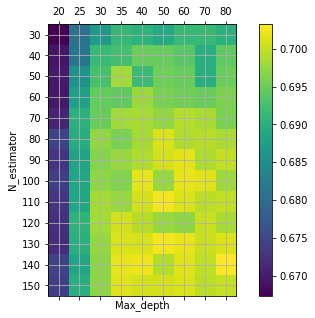

In [90]:

AA=list(A)
KK=list(K+K1)
f, ax = plt.subplots(1, 1, figsize=(8, 5))
cax = ax.matshow(temp2, interpolation='nearest') 
f.colorbar(cax)
ax.set_xticklabels(AA) 
ax.set_yticks(np.arange(0, len(temp), 1)) 
ax.set_xticks(np.arange(0, 9, 1)) 
ax.set_yticklabels(KK)
plt.grid()
plt.ylabel('N_estimator')
plt.xlabel("Max_depth")
plt.show()

In [92]:
forest = RandomForestClassifier(n_estimators = 140, max_depth=80, criterion = "entropy", 
                                        min_samples_split=10)
forest.fit(X_train, Y_train)
Y_test_predict = forest.predict(X_test)
en_auc=accuracy_score(Y_test, Y_test_predict)
forest = RandomForestClassifier(n_estimators = 140, max_depth=80, criterion = "gini", 
                                        min_samples_split=10)
forest.fit(X_train, Y_train)
Y_test_predict = forest.predict(X_test)
gi_auc=accuracy_score(Y_test, Y_test_predict)
print(en_auc,gi_auc)

0.6995972203779932 0.7023856946841942


In [93]:
forest = RandomForestClassifier(n_estimators = 150, max_depth=90, criterion = "entropy", 
                                        min_samples_split=10)
forest.fit(X_train, Y_train)
Y_test_predict = forest.predict(X_test)
en_auc=accuracy_score(Y_test, Y_test_predict)
forest = RandomForestClassifier(n_estimators = 150, max_depth=90, criterion = "gini", 
                                        min_samples_split=10)
forest.fit(X_train, Y_train)
Y_test_predict = forest.predict(X_test)
gi_auc=accuracy_score(Y_test, Y_test_predict)
print(en_auc,gi_auc)

0.7008365422918603 0.703447970610366


In [97]:
K2 = [150,160,180,200,220,240] # Or something else# #
A2 = [70,80,90,100,110] # Or something else 
temp3 = np.zeros((len(K2),len(A2)))
for i,k in enumerate(K2):
    for j,a in enumerate(A2):
        print(1)
        forest = RandomForestClassifier(n_estimators = k, max_depth=a, criterion = "entropy", 
                                        min_samples_split=10)
        forest.fit(X_train, Y_train)
        Y_test_predict = forest.predict(X_test)
        temp3[i][j]=accuracy_score(Y_test, Y_test_predict)
        print(temp3[i][j])

1


0.70141194175187
1


0.6994644358872217
1


0.7007480192980127
1


0.701943079714956
1


0.7015889877395654
1


0.7024742176780419
1


0.7031381401318992
1


0.6990218209179835
1


0.6989775594210597
1


0.7008365422918603
1


0.7013234187580224
1


0.7021201257026513
1


0.7000840968441553
1


0.7025184791749657
1


0.7017660337272607
1


0.7018545567211083
1


0.7035807551011375
1


0.7000398353472315
1


0.7011906342672509
1


0.6996857433718409
1


0.701943079714956
1


0.7038463240826804
1


0.699641481874917
1


0.7020758642057274
1


0.7016332492364892
1


0.7023856946841942
1


0.7043332005488425
1


0.7026070021688133
1


0.701943079714956
1


0.7020758642057274


In [132]:
K3 = [150,160,180,200,220,240,250,280,300,350,400] # Or something else# #
A2 = [50,60,70,80,90,100] # Or something else 
temp4 = np.zeros((len(K3),len(A2)))
temp4_tr = np.zeros((len(K3),len(A2)))
for i,k in enumerate(K3):
    for j,a in enumerate(A2):
        
        forest = RandomForestClassifier(n_estimators = k, max_depth=a, criterion = "gini", 
                                        min_samples_split=2)
        forest.fit(X_train, Y_train)
        Y_test_predict = forest.predict(X_test)
        temp4[i][j]=accuracy_score(Y_test, Y_test_predict)
        Y_train_predict = forest.predict(X_train)
        temp4_tr[i][j]=accuracy_score(Y_train, Y_train_predict)
        print(temp4[i][j],temp4_tr[i][j])

0.719736201478334 1.0


0.7186739255521621 1.0


0.7169034656752091 1.0


0.719470632496791 1.0


0.7190280175275527 1.0


0.7193378480060195 1.0


0.717700172619838 1.0


0.7195591554906386 1.0


0.7183198335767715 1.0


0.7211525693798965 1.0


0.7207099544106582 1.0


0.7190722790244766 1.0


0.7215509228522109 1.0


0.7214623998583632 1.0


0.7208870003983535 1.0


0.7195591554906386 1.0


0.7188509715398574 1.0


0.7190722790244766 1.0


0.7218607533306777 1.0


0.723055813747621 1.0


0.7230115522506971 1.0


0.7214181383614394 1.0


0.7201345549506484 1.0


0.7213738768645156 1.0


0.7213738768645156 1.0


0.7211968308768203 1.0


0.7195591554906386 1.0


0.7210640463860488 1.0


0.7207099544106582 1.0


0.7208427389014297 1.0


0.7217279688399062 1.0


0.7217279688399062 1.0


0.7215066613552871 1.0


0.7213738768645156 1.0


0.721285353870668 1.0


0.7200902934537246 1.0


0.721285353870668 1.0


0.7200902934537246 1.0


0.7210640463860488 1.0


0.7186739255521621 1.0


0.7185411410613907 1.0


0.7231885982383924 1.0


0.7211083078829726 1.0


0.7215066613552871 1.0


0.7208427389014297 1.0


0.7210640463860488 1.0


0.7241180896737928 1.0


0.7217279688399062 1.0


0.7219492763245253 1.0


0.7224361527906874 1.0


0.7218164918337538 1.0


0.7217279688399062 1.0


0.7206656929137344 1.0


0.7232328597353163 1.0


0.7213296153675918 1.0


0.721285353870668 1.0


0.7214181383614394 1.0


0.7219935378214491 1.0


0.7218607533306777 1.0


0.7228787677599257 1.0


0.7229230292568495 1.0


0.7223033682999159 1.0


0.7242508741645642 1.0


0.7205771699198867 1.0


0.7214181383614394 1.0


0.7232328597353163 1.0


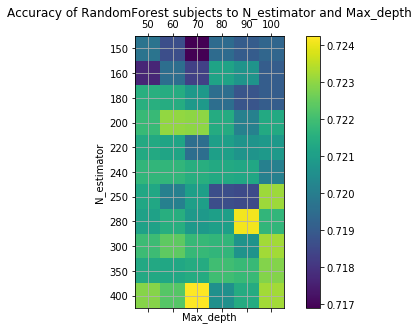

In [138]:
AA=list(A2)
KK=list(K3)
f, ax = plt.subplots(1, 1, figsize=(8, 5))
cax = ax.matshow(temp4, interpolation='nearest') 
f.colorbar(cax)
ax.set_xticklabels(AA) 
ax.set_yticks(np.arange(0, len(temp4), 1)) 
ax.set_xticks(np.arange(0, 6, 1)) 
ax.set_yticklabels(KK)
plt.grid()
plt.ylabel('N_estimator')
plt.xlabel("Max_depth")
plt.title("Accuracy of RandomForest subjects to N_estimator and Max_depth")
plt.show()

In [102]:
forest = RandomForestClassifier(n_estimators = 240, max_depth=80, criterion = "entropy", 
                                        min_samples_split=10)
forest.fit(X_train, Y_train)
Y_test_predict = forest.predict(X_test)
en_auc=accuracy_score(Y_test, Y_test_predict)
forest = RandomForestClassifier(n_estimators = 240, max_depth=80, criterion = "gini", 
                                        min_samples_split=10)
forest.fit(X_train, Y_train)
Y_test_predict = forest.predict(X_test)
gi_auc=accuracy_score(Y_test, Y_test_predict)
print(en_auc,gi_auc)

0.7021201257026513 0.7038905855796043


In [114]:
M = [2,3,4,5] # Or something else# #
L = [1,2,3,4,5] # Or something else 
te1 = np.zeros((len(M),len(L)))
tr1=np.zeros((len(M),len(L)))
for i,k in enumerate(M):
    for j,a in enumerate(L):
       
        forest = RandomForestClassifier(n_estimators = 240, max_depth=80, criterion = "gini",  
                                        min_samples_split=k,min_samples_leaf=a)
        forest.fit(X_train, Y_train)
       # Y_test_predict = forest.predict(X_test)
        Y_train_predict = forest.predict(X_train)
       # te1[i][j]=accuracy_score(Y_test, Y_test_predict)
        tr1[i][j]=accuracy_score(Y_train,Y_train_predict)
        print(te1[i][j],tr1[i][j])

0.7216394458460585 1.0


0.7110166865843403 0.9953634542818887


0.7016332492364892 0.9670462216025407


0.6950382861948391 0.9343912182274895


0.686672863276236 0.905852670716728


0.7162838047182756 1.0


0.7096445801797017 0.9954630459560248


0.7023856946841942 0.9663712113667298


0.69481697871022 0.9334838274186945


0.6867613862700837 0.9056424216268854


0.7170805116629044 0.9999114740674346


0.7106183331120258 0.9955073089223074


0.7021643871995751 0.966227356726311


0.6942415792502102 0.9341588376545055


0.6904350905147613 0.9054321725370426


0.7153100517859514 0.9987053082362315


0.709556057185854 0.9906605141143534


0.702429956181118 0.9666810521307085


0.6954366396671535 0.9341035089466521


0.6887531536316558 0.9062067744469896


get the optimal this one first, then get the max_depth ! at the same time, get the 

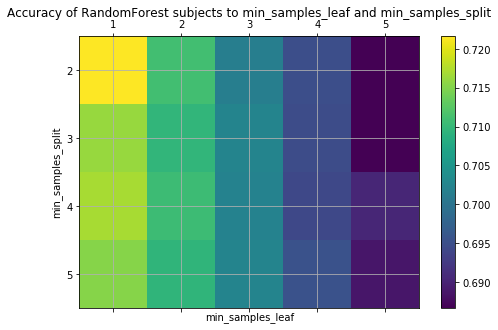

In [144]:
AA=list(M)
KK=list(L)
f, ax = plt.subplots(1, 1, figsize=(8, 5))
cax = ax.matshow(te1, interpolation='nearest') 
f.colorbar(cax)
ax.set_xticklabels(KK) 
#ax.set_yticks(np.arange(0, len( KK), 1)) 
ax.set_xticks(np.arange(0, 5, 1)) 
ax.set_yticks(np.arange(0, 4, 1)) 
ax.set_yticklabels(AA)
plt.grid()
plt.ylabel('min_samples_split')
plt.xlabel("min_samples_leaf")
plt.title("Accuracy of RandomForest subjects to min_samples_leaf and min_samples_split")
plt.show()

In [142]:
K3 = [150,160,180,200,220,240,250,280,300,350,400] # Or something else# #
A2 = [50,60,70,80,90,100] # Or something else 
cross_auc = np.zeros((len(K3),len(A2)))
#temp4_tr = np.zeros((len(K3),len(A2)))
for i,k in enumerate(K3):
    for j,a in enumerate(A2):
        
        forest = RandomForestClassifier(n_estimators = k, max_depth=a, criterion = "gini", 
                                        min_samples_split=2)
        forest.fit(X_train, Y_train)
        
        cross_auc[i][j] = np.mean(cross_val_score(forest, X_train, Y_train, cv=8))
        #cross_auc[i][j]=accuracy_score(Y_test, Y_test_predict)
        print(cross_auc[i][j] ) 

0.7169383259716848


0.7164625163481317


0.7158870679099919


0.7152010362562098


0.7163297093276788


0.7156325765464321


0.7160420536764128


0.7158428475536638


0.7169383367466255


0.7156215067642491


0.7147584212861045


0.7160088198413628


0.7174141414724784


0.7168830142832926


0.7159313421410232


0.7167723409499652


0.7156104536342471


0.7161084312288278


0.7174363358910875


0.7169825904073156


0.7155330023814892


0.7170821929789202


0.7174584323556907


0.7180670754472784


0.7172813991016693


0.717701910750391


0.7175912197853425


0.7172592379874223


0.7164072095574398


0.717646568696257


0.7173477766540842


0.7178125223726949


0.7178568259899278


0.7173256615782199


0.7173588513339675


0.717624390929829


0.7185871641995631


0.7183436867844029


0.7167170547296144


0.7163518479125045


0.7170268861882282


0.7176465804507377


0.718144484579814


0.718387956117734


0.7165399803349105


0.7174695187900546


0.7178235990116582


0.7179121337601599


0.7179453626975099


0.7184100956820996


0.7185871475473822


0.7177350887516578


0.718354759505206


0.7181113202921079


0.7182441302511811


0.718730989086576


0.718576055235778


0.7176908145206266


0.7179674944255551


0.7180449329442924


0.7191072382587471


0.7183990445111779


0.7188859131419734


0.719428126765523


0.7187752525426666


0.7188416702562239


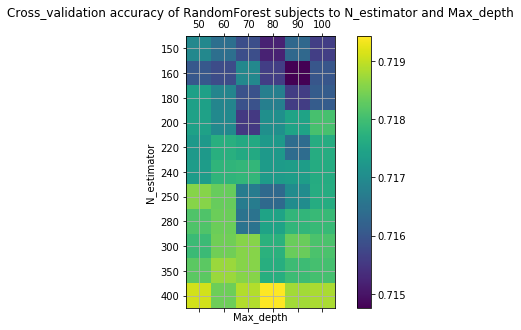

In [146]:
AA=list(A2)
KK=list(K3)
f, ax = plt.subplots(1, 1, figsize=(8, 5))
cax = ax.matshow(cross_auc, interpolation='nearest') 
f.colorbar(cax)
ax.set_xticklabels(AA) 
ax.set_yticks(np.arange(0, len(temp4), 1)) 
ax.set_xticks(np.arange(0, 6, 1)) 
ax.set_yticklabels(KK)
plt.grid()
plt.ylabel('N_estimator')
plt.xlabel("Max_depth")
plt.title("Cross_validation accuracy of RandomForest subjects to N_estimator and Max_depth")
plt.show()

In [148]:
M = [2,3,4,5] # Or something else# #
L = [1,2,3,4,5] # Or something else 
cross_auc2 = np.zeros((len(M),len(L)))

for i,k in enumerate(M):
    for j,a in enumerate(L):
       
        forest = RandomForestClassifier(n_estimators = 240, max_depth=80, criterion = "gini",  
                                        min_samples_split=k,min_samples_leaf=a)
        cross_auc2[i][j] = np.mean(cross_val_score(forest, X_train, Y_train, cv=8))
        
       
        print(cross_auc2[i][j])

0.7174694835266126


0.70841770471008


0.6996647130380198


0.691199400526187


0.6845931541497016


0.7162744172300877


0.707587777642401


0.6977614098941632


0.6912768743083664


0.6846927420282052


0.7139616722196923


0.7085947683298431


0.6978278011601391


0.6914207001749193


0.6844825004071753


0.7117264039300966


0.705573837408199


0.6991556764361969


0.6910887702926221


0.6842833422818888


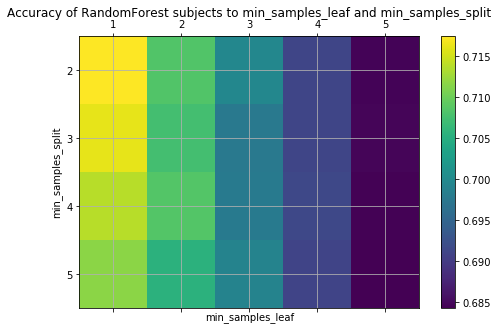

In [ ]:
AA=list(M)
KK=list(L)
f, ax = plt.subplots(1, 1, figsize=(8, 5))
cax = ax.matshow(cross_auc2, interpolation='nearest') 
f.colorbar(cax)
ax.set_xticklabels(KK) 
#ax.set_yticks(np.arange(0, len( KK), 1)) 
ax.set_xticks(np.arange(0, 5, 1)) 
ax.set_yticks(np.arange(0, 4, 1)) 
ax.set_yticklabels(AA)
plt.grid()
plt.ylabel('min_samples_split')
plt.xlabel("min_samples_leaf")
plt.title("Cross_validation of RandomForest subjects to min_samples_leaf and min_samples_split")
plt.show()

In [159]:
print(cross_auc2)

[[0.71746948 0.7084177  0.69966471 0.6911994  0.68459315]
 [0.71627442 0.70758778 0.69776141 0.69127687 0.68469274]
 [0.71396167 0.70859477 0.6978278  0.6914207  0.6844825 ]
 [0.7117264  0.70557384 0.69915568 0.69108877 0.68428334]]


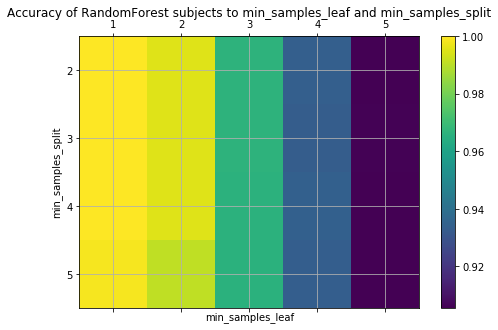

In [158]:
AA=list(M)
KK=list(L)
f, ax = plt.subplots(1, 1, figsize=(8, 5))
cax = ax.matshow(tr1, interpolation='nearest') 
f.colorbar(cax)
ax.set_xticklabels(KK) 
#ax.set_yticks(np.arange(0, len( KK), 1)) 
ax.set_xticks(np.arange(0, 5, 1)) 
ax.set_yticks(np.arange(0, 4, 1)) 
ax.set_yticklabels(AA)
plt.grid()
plt.ylabel('min_samples_split')
plt.xlabel("min_samples_leaf")
plt.title("Accuracy of RandomForest subjects to min_samples_leaf and min_samples_split")
plt.show()

In [154]:
M = [2,3,4,5] # Or something else# #
L = [1,2,3,4,5] # Or something else 

tr1=np.zeros((len(M),len(L)))
for i,k in enumerate(M):
    for j,a in enumerate(L):
       
        forest = RandomForestClassifier(n_estimators = 240, max_depth=80, criterion = "gini",  
                                        min_samples_split=k,min_samples_leaf=a)
        forest.fit(X_train, Y_train)
       # Y_test_predict = forest.predict(X_test)
        Y_train_predict = forest.predict(X_train)
       # te1[i][j]=accuracy_score(Y_test, Y_test_predict)
        tr1[i][j]=accuracy_score(Y_train,Y_train_predict)
        print(tr1[i][j])

1.0


0.995352388540318


0.9665482632318605


0.934003917272516


0.9055870929190319


1.0


0.99521959964147


0.9667142493554206


0.9336055505759718


0.9060186568402882


0.9997897509101572


0.9954187829897421


0.9663822771083004


0.9346899932498977


0.9058194734920161


0.9987495712025142


0.9908043687547721


0.9659728446701856


0.9336940765085372


0.9056424216268854


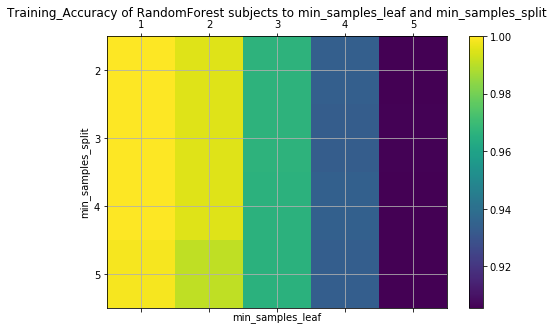

In [156]:
AA=list(M)
KK=list(L)
f, ax = plt.subplots(1, 1, figsize=(8, 5))
cax = ax.matshow(tr1, interpolation='nearest') 
f.colorbar(cax)
ax.set_xticklabels(KK) 
#ax.set_yticks(np.arange(0, len( KK), 1)) 
ax.set_xticks(np.arange(0, 5, 1)) 
ax.set_yticks(np.arange(0, 4, 1)) 
ax.set_yticklabels(AA)
plt.grid()
plt.ylabel('min_samples_split')
plt.xlabel("min_samples_leaf")
plt.title("Training_Accuracy of RandomForest subjects to min_samples_leaf and min_samples_split")
plt.show()